In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from tqdm import tqdm
# %run ConV_VAE.ipynb
# %run bigger_latent_space.ipynb
%run rgb200x200.ipynb
%run loader.ipynb
%run test.ipynb
%run train.ipynb

In [10]:
plt.rcParams['figure.dpi'] = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False
# specify which model you want to load
model_name = None
img_size = 200
batch_size = 2

In [17]:
from torchvision import datasets

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
# train_data = datasets.ImageFolder('./data/asl_dataset', transform=transform)
train_data =

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
for batch in train_loader:
    input, labels = batch
    print(input.shape)
    break

TypeError: 'AutoAugmentPolicy' object is not callable

In [5]:
model = cVAE((3, img_size, img_size), 36).to(device)

BCE_loss = torch.nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean ** 2)
    return reconstruction_loss + KL_divergence

In [10]:
import time

lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.0001)
early_stop = EarlyStop(patience=5, save_name="model.pt")


def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate


max_epochs = 5
net = model.to(device)
if load:
    checkpoint = torch.load("model.pt", map_location=device)
    net.load_state_dict(checkpoint["net"])
    net.to(device)
    print("model loaded")
train_losses = []
print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm(train_loader, ncols=50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    train_losses.append(train_loss)
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    if (early_stop(train_loss, net, optimizer)):
        break

training on  cuda


100%|█████████| 1257/1257 [02:25<00:00,  8.64it/s]


epoch 0, train loss 44470.7978 , time 145.5 sec
model saved


100%|█████████| 1257/1257 [02:30<00:00,  8.35it/s]


epoch 1, train loss 43681.9387 , time 150.5 sec
model saved


100%|█████████| 1257/1257 [02:35<00:00,  8.06it/s]


epoch 2, train loss 43360.1770 , time 155.9 sec
model saved


100%|█████████| 1257/1257 [02:45<00:00,  7.62it/s]


epoch 3, train loss 43939.4902 , time 165.0 sec
EarlyStopping counter: 1 out of 5


100%|█████████| 1257/1257 [02:44<00:00,  7.66it/s]

epoch 4, train loss 44438.9723 , time 164.1 sec
EarlyStopping counter: 2 out of 5


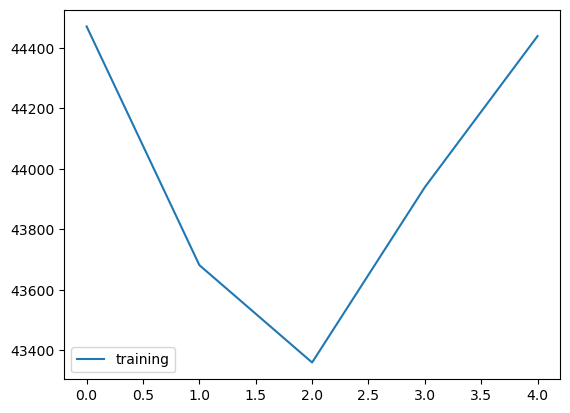

In [11]:
plt.plot(train_losses, label="training")
plt.legend()
plt.show()

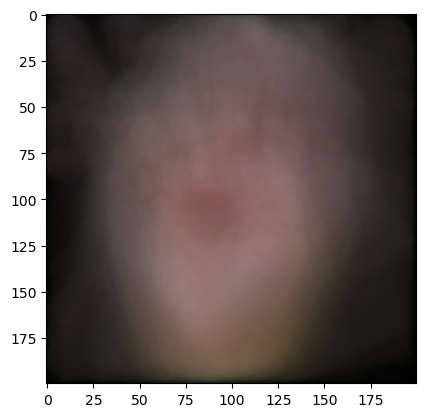

In [9]:
from matplotlib import cm

checkpoint = torch.load("model.pt", map_location=device)
net = cVAE((3, img_size, img_size), 36).to(device)
net.load_state_dict(checkpoint["net"])
net.to(device)
net.eval()

number = 0
with torch.no_grad():
    x = net.generate(number)
x = x.transpose(0, 2).transpose(0, 1)
plt.imshow(x.squeeze(0).cpu().numpy(), cm.gray)

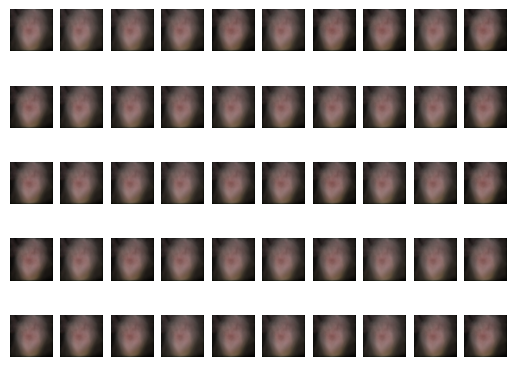

In [7]:
with torch.no_grad():
    x = net.generate(torch.tensor([list(range(10))] * 5).clone().view(-1))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.axis("off")
    img = x[i].transpose(0, 2).transpose(0, 1)
    plt.imshow(img.squeeze(0).cpu().numpy(), cm.gray)

In [16]:
print(net)